In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cmath
import warnings
from scipy.io.wavfile import write
#import sounddevice as sd

**Proof of Theorem 1**\
First, write x as a sum of complex exponentials.\
$x(n) = \frac{1}{\sqrt(N)} \sum_{k=0} ^ {N-1} X(k)e^{j2 \pi kn/N}$ \
$= \frac{1}{\sqrt(N)} \sum_{k=-N/2 + 1} ^ {N/2} X(k)e^{j2 \pi kn/N}$ \
Coefficient multiplying $e^{j2 \pi kn/N}$ is X(k) = kth element of the DFT of x.\
$X(k) :=  \frac{1}{\sqrt(N)} \sum_{n = 0} ^ {N-1} x(n)e^{-j2 \pi kn/N}$
To prove this, let X = F(x) be the DFT of x. Let $\tilde{x}$ = F^{-1}(X) be the inverse DFT of X.\
In order to prove the theorem, we must show that $\tilde{x} = x$\
We can use the definition of the inverse DFT for X to get \
$\tilde{x}(\tilde{n}) = \frac{1}{\sqrt(N)} \sum_{k=0} ^ {N-1} X(k)e^{j2 \pi k \tilde{n} /N}$\
We can use the definition of the inverse DFT for x to get \
$X(k) := \frac{1}{\sqrt(N)} \sum_{n=0} ^ {N-1} x(n)e^{-j2 \pi kn /N}$\
Substitute to get : \
$\tilde{x}(\tilde{n}) = \frac{1}{\sqrt(N)} \sum_{k=0} ^ {N-1} [\frac{1}{\sqrt(N)} \sum_{n=0} ^ {N-1} x(n)e^{-j2 \pi kn /N}] e^{j2 \pi k \tilde{n} /N}$\
We chan switch the summation order and pull the x(n) out of the inner summation because it doesn't depend on k.\
$\tilde{x}(\tilde{n}) = \sum_{n=0} ^ {N-1} x(n)[\sum_{k=0} ^ {N-1} \frac{1}{\sqrt(N)}e^{j2 \pi k \tilde{n} /N}\frac{1}{\sqrt(N)}e^{-j2 \pi kn /N}]$ \
We can then use orthonomrality to convert the inner summation to: \
$ \delta (\tilde{n} - n)$ \
We can sub that back in to get: \
$\tilde{x}(\tilde{n}) = \sum_{n=0} ^ {N-1} x(n) \delta (\tilde{n} - n)$ \
which reduces to $x(\tilde{n})$

In [2]:
class ComplexExp(object):
   def __init__(self, k, N):
        self.k = k
        self.N = N

        self.n = np.arange(N)
        self.exp_kN = np.exp(2j*cmath.pi*k*self.n/ N)
        self.exp_kN *= 1 / (np.sqrt(N))

        # Real and imaginary parts
        self.exp_kN_real = self.exp_kN.real
        self.exp_kN_imag = self.exp_kN.imag

In [3]:
class Tripulse():
    """
    sqpulse Generates a triangular spulse
    solve() generates a triangular pulse vector x of length N
    """
    def __init__(self, T, T0, fs):
        """
        :param T: the duration
        :param T0: nonzero length
        :param fs: the sampling frequency
        """
        self.T = T
        self.T0 = T0
        self.fs = fs
                
    def solve(self):
        """
        :return: [x,N]
        :x: the triangular pulse vector x
        :N: The sample duration
        """
        Ts = 1/self.fs
        N = math.floor(self.T/Ts)
        M = math.floor(self.T0/Ts)
        x = np.zeros(N)
        
        for i in range(int(M/2)):
            x[i] = i
            x[M-i-1] = i

        energy = np.linalg.norm(x)
            
        for i in range(M):
            x[i] = x[i]/energy  
        
        return x, N
		
class Sqpulse():
    """
    sqpulse Generates a square spulse
    solve() generates a square pulse vector x of length N
    """
    def __init__(self, T, T0, fs):
        """
        :param T: the duration
        :param T0: nonzero length
        :param fs: the sampling frequency
        """
        self.T = T
        self.T0 = T0
        self.fs = fs
                
    def solve(self):
        """
        :return: [x,N]
        :x: the square pulse vector x
        :N: The sample duration
        """
        Ts = 1/self.fs
        N = math.floor(self.T/Ts)
        M = math.floor(self.T0/Ts)
        x = np.zeros(N)
        
        for i in range(M):
            x[i] = 1/np.sqrt(M)
        
        return x, N

class Dft():
    def __init__(self, X, fs, K=None):
        self.X=X
        self.fs=fs
        self.N=len(X)
        if K == None:
            K = len(self.X)
        self.K=K
        self.f=np.arange(self.K)*self.fs/self.K
        self.f_c=np.arange(-np.ceil(K/2)+1,np.floor(self.K/2)+1)*self.fs/self.K

    def first(self):
        X = np.fft.fft(self.X,self.K, norm='ortho')/np.sqrt(self.N)
        X_c=np.roll(self.X,np.int(np.ceil(self.K/2-1))) 
        return [self.f,X,self.f_c,X_c]

def energy(f, X,  interval):

    aux=0
    for i,freq in enumerate(f):
        if freq>=interval[0] and freq<=interval[1]:
            aux=aux+abs(X[i]*np.conjugate(X[i]))

    return aux


In [4]:
#Finalized part 1.1
class Inversedft():
    def __init__(self, X, N, fs, K=None):
        self.X = X
        self.N = N
        self.fs = fs
        self.K= K
        if self.K==None:
            self.K=int(len(X)/2)-1

    def idft_basic(self):
        x = np.zeros(self.N)
        for n in range(self.N):
            x[n] = (self.X[0]*np.exp(1j*2*cmath.pi*n/self.N))*(1/np.sqrt(self.N))
            for k in range(1, self.N):
                x[n] = x[n] + np.exp(1j*2*cmath.pi*k*n/self.N)*(1/np.sqrt(self.N)*self.X[k])
                x[n] = x[n] + np.conj((self.X[k]*np.exp(-1j*2*cmath.pi*n/self.N)))*(1/np.sqrt(self.N))
            
        Ts = 1/self.fs
        T = np.arange(self.N)*Ts
        return T, x

In [5]:
class inverseDft():

    def __init__(self, X, fs, N, K=None):
    #X = input dft
    #ds = sampling freq
    #N = num of signal samples
    #K = num of coefficients used
        self.X=X
        self.fs=fs
        self.N=N 
        self.K=K
        if self.K==None:
            self.K=int(N/2)-1

    
    def signalReconstruction(self):
        x=np.fft.ifft(self.X,self.N)*np.sqrt(self.N)
         #x = reconstructed signal       
        realTimes= np.arange(self.N)*(1/self.fs)
        return x, realTimes

In [6]:
#reconstruction is the difference between x and X
class Reconstruction():
    def __init__(self, X_k, fs):
        self.X = X_k
        self.fs = fs
        self.K = self.X.shape[0]
        self.N = len(fs)

    def reconstruction(self):
        x = Inversedft.idft_basic(self.X, self.N, self.fs)
        x = Dft.first(x, self.fs)*np.sqrt(self.N)
        T_real = np.arange(self.N)*(1/self.fs)
        return x, T_real

        #for i in range(self.N):
         #   for n in range():
          #      x[i] = x[i] + np.exp(1j*2*cmath.pi*n*n/self.N)*(1/np.sqrt(self.N)*self.X[n])

/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:86: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_c=np.roll(self.X,np.int(np.ceil(self.K/2-1)))
/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:111: ComplexWarning: Casting complex values to real discards the imaginary part
  x[n] = (self.X[0]*np.exp(1j*2*cmath.pi*n/self.N))*(1/np.sqrt(self.N))
/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:113: ComplexWarning: Casting complex values to real discards the imagin

0.8036311433314552


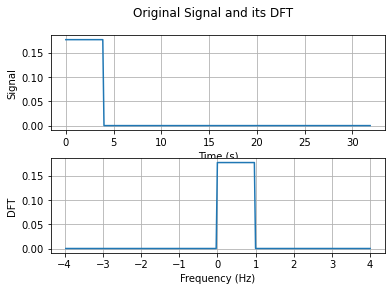

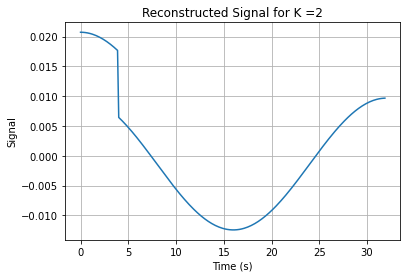

In [7]:
import matplotlib.pyplot as plt
import cmath
import numpy as np
import math
class Tripulse():
    """
    sqpulse Generates a triangular spulse
    solve() generates a triangular pulse vector x of length N
    """
    def __init__(self, T, T0, fs):
        """
        :param T: the duration
        :param T0: nonzero length
        :param fs: the sampling frequency
        """
        self.T = T
        self.T0 = T0
        self.fs = fs
                
    def solve(self):
        """
        :return: [x,N]
        :x: the triangular pulse vector x
        :N: The sample duration
        """
        Ts = 1/self.fs
        N = math.floor(self.T/Ts)
        M = math.floor(self.T0/Ts)
        x = np.zeros(N)
        
        for i in range(int(M/2)):
            x[i] = i
            x[M-i-1] = i

        energy = np.linalg.norm(x)
            
        for i in range(M):
            x[i] = x[i]/energy  
        
        return x, N
		
class Sqpulse():
    """
    sqpulse Generates a square spulse
    solve() generates a square pulse vector x of length N
    """
    def __init__(self, T, T0, fs):
        """
        :param T: the duration
        :param T0: nonzero length
        :param fs: the sampling frequency
        """
        self.T = T
        self.T0 = T0
        self.fs = fs
                
    def solve(self):
        """
        :return: [x,N]
        :x: the square pulse vector x
        :N: The sample duration
        """
        Ts = 1/self.fs
        N = math.floor(self.T/Ts)
        M = math.floor(self.T0/Ts)
        x = np.zeros(N)
        
        for i in range(M):
            x[i] = 1/np.sqrt(M)
        
        return x, N

class Dft():
    def __init__(self, X, fs, K=None):
        self.X=X
        self.fs=fs
        self.N=len(X)
        if K == None:
            K = len(self.X)
        self.K=K
        self.f=np.arange(self.K)*self.fs/self.K
        self.f_c=np.arange(-np.ceil(K/2)+1,np.floor(self.K/2)+1)*self.fs/self.K

    def first(self):
        X = np.fft.fft(self.X,self.K, norm='ortho')/np.sqrt(self.N)
        X_c=np.roll(self.X,np.int(np.ceil(self.K/2-1))) 
        return [self.f,X,self.f_c,X_c]

def energy(f, X,  interval):

    aux=0
    for i,freq in enumerate(f):
        if freq>=interval[0] and freq<=interval[1]:
            aux=aux+abs(X[i]*np.conjugate(X[i]))

    return aux

#Finalized part 1.1
class Inversedft():
    def __init__(self, X, N, fs, K=None):
        self.X = X
        self.N = N
        self.fs = fs
        self.K= K
        if self.K==None:
            self.K=int(len(X)/2)-1

    def idft_basic(self):
        x = np.zeros(self.N)
        for n in range(self.N):
            x[n] = (self.X[0]*np.exp(1j*2*cmath.pi*n/self.N))*(1/np.sqrt(self.N))
            for k in range(1, self.N):
                x[n] = x[n] + np.exp(1j*2*cmath.pi*k*n/self.N)*(1/np.sqrt(self.N)*self.X[k])
                x[n] = x[n] + np.conj((self.X[k]*np.exp(-1j*2*cmath.pi*n/self.N)))*(1/np.sqrt(self.N))
            
        Ts = 1/self.fs
        T = np.arange(self.N)*Ts
        return T, x
        
def q_13(T, fs, T0, K):
    for k in K:
        sq_pulse = Sqpulse(T, T0, fs)
        x, N = sq_pulse.solve()
        sq_dft = Dft(x, fs)
        [f, X, f_c, X_c] = sq_dft.first()
        sq_idft = Inversedft(X, N, fs)
        Treal, x_k = sq_idft.idft_basic()

        x_diff = x - x_k    #compute the energe difference
        energy_diff = np.linalg.norm(x_diff)*np.linalg.norm(x_diff)   
        print(energy_diff)
          
        fig, axs = plt.subplots(2)
        axs[0].grid()
        axs[1].grid()
        fig.suptitle('Original Signal and its DFT' )
        fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
        axs[0].plot(Treal, x)
        axs[0].set_xlabel('Time (s)')
        axs[0].set_ylabel('Signal')
        axs[1].plot(f_c, abs(X_c))
        axs[1].set_xlabel('Frequency (Hz)')
        axs[1].set_ylabel('DFT')
        plt.show()    
        
        plt.figure()
        plt.grid(True)
        plt.title('Reconstructed Signal for K =' + str(k))
        plt.plot(Treal, x_k)
        plt.xlabel('Time (s)')
        plt.ylabel('Signal')
        plt.show()

q_13(32, 8, 4, [2])
    

/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:86: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_c=np.roll(self.X,np.int(np.ceil(self.K/2-1)))
/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:111: ComplexWarning: Casting complex values to real discards the imaginary part
  x[n] = (self.X[0]*np.exp(1j*2*cmath.pi*n/self.N))*(1/np.sqrt(self.N))
/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:113: ComplexWarning: Casting complex values to real discards the imagin

0.8036311433314552


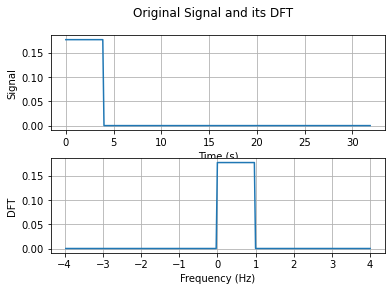

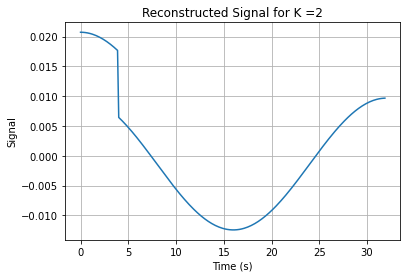

/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:86: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_c=np.roll(self.X,np.int(np.ceil(self.K/2-1)))
/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:111: ComplexWarning: Casting complex values to real discards the imaginary part
  x[n] = (self.X[0]*np.exp(1j*2*cmath.pi*n/self.N))*(1/np.sqrt(self.N))
/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:113: ComplexWarning: Casting complex values to real discards the imagin

0.8036311433314552


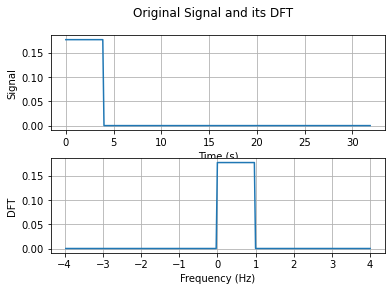

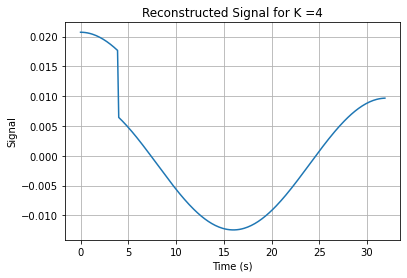

/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:86: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_c=np.roll(self.X,np.int(np.ceil(self.K/2-1)))
/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:111: ComplexWarning: Casting complex values to real discards the imaginary part
  x[n] = (self.X[0]*np.exp(1j*2*cmath.pi*n/self.N))*(1/np.sqrt(self.N))
/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:113: ComplexWarning: Casting complex values to real discards the imagin

0.8036311433314552


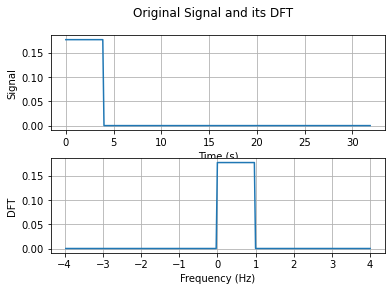

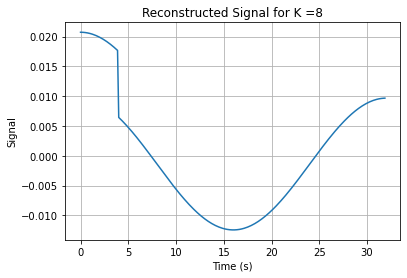

/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:86: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_c=np.roll(self.X,np.int(np.ceil(self.K/2-1)))
/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:111: ComplexWarning: Casting complex values to real discards the imaginary part
  x[n] = (self.X[0]*np.exp(1j*2*cmath.pi*n/self.N))*(1/np.sqrt(self.N))
/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:113: ComplexWarning: Casting complex values to real discards the imagin

0.8036311433314552


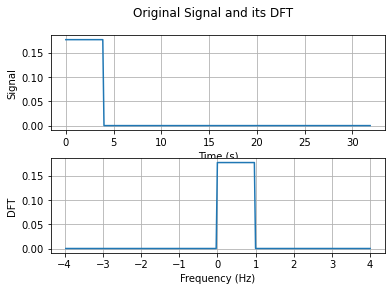

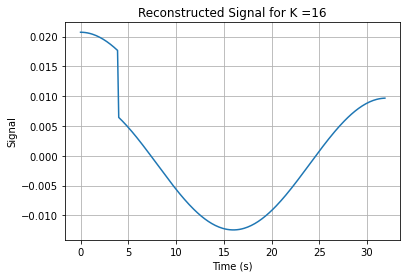

/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:86: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_c=np.roll(self.X,np.int(np.ceil(self.K/2-1)))
/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:111: ComplexWarning: Casting complex values to real discards the imaginary part
  x[n] = (self.X[0]*np.exp(1j*2*cmath.pi*n/self.N))*(1/np.sqrt(self.N))
/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:113: ComplexWarning: Casting complex values to real discards the imagin

0.8036311433314552


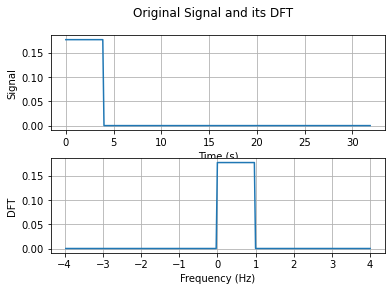

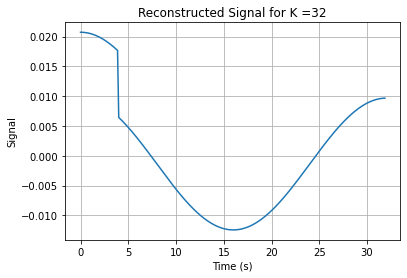

In [8]:
q_13(32, 8, 4, [2,4,8,16,32])

/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:86: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_c=np.roll(self.X,np.int(np.ceil(self.K/2-1)))
/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:111: ComplexWarning: Casting complex values to real discards the imaginary part
  x[n] = (self.X[0]*np.exp(1j*2*cmath.pi*n/self.N))*(1/np.sqrt(self.N))
/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:113: ComplexWarning: Casting complex values to real discards the imagin

1
0.8898925781250002


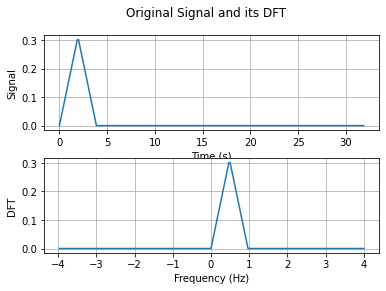

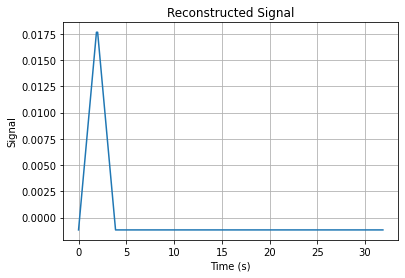

In [9]:


def q_14(T, fs, T0, K):
    for k in K:
        tri_pulse = Tripulse(T, T0, fs)
        x, N = tri_pulse.solve()
        tri_dft = Dft(x, fs)
        [f, X, f_c, X_c] = tri_dft.first()
        tri_dft = Inversedft(X, N, fs)
        Treal, x_k = tri_dft.idft_basic()
        print(X.ndim)
        x_diff = x - x_k    #compute the energe difference
        energy_diff = np.linalg.norm(x_diff)*np.linalg.norm(x_diff)   
        print(energy_diff)

        fig, axs = plt.subplots(2)
        axs[0].grid()
        axs[1].grid()
        fig.suptitle('Original Signal and its DFT' )
        fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
        axs[0].plot(Treal, x)
        axs[0].set_xlabel('Time (s)')
        axs[0].set_ylabel('Signal')
        axs[1].plot(f_c, abs(X_c))
        axs[1].set_xlabel('Frequency (Hz)')
        axs[1].set_ylabel('DFT')
        plt.show()    
        
        plt.figure()
        plt.grid(True)
        plt.title('Reconstructed Signal')
        plt.plot(Treal, x_k)
        plt.xlabel('Time (s)')
        plt.ylabel('Signal')
        plt.savefig('Square_reconstructed.png')
        plt.show()


q_14(32, 8, 4, [2])

/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:86: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_c=np.roll(self.X,np.int(np.ceil(self.K/2-1)))
/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:111: ComplexWarning: Casting complex values to real discards the imaginary part
  x[n] = (self.X[0]*np.exp(1j*2*cmath.pi*n/self.N))*(1/np.sqrt(self.N))
/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:113: ComplexWarning: Casting complex values to real discards the imagin

1
0.8898925781250002


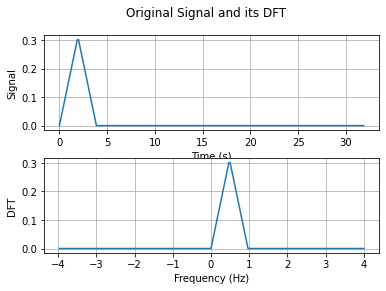

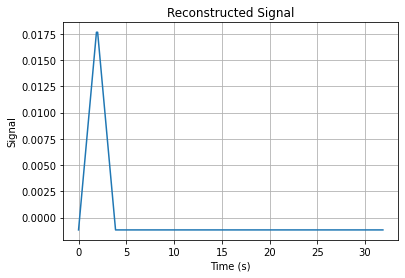

/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:86: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_c=np.roll(self.X,np.int(np.ceil(self.K/2-1)))
/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:111: ComplexWarning: Casting complex values to real discards the imaginary part
  x[n] = (self.X[0]*np.exp(1j*2*cmath.pi*n/self.N))*(1/np.sqrt(self.N))
/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:113: ComplexWarning: Casting complex values to real discards the imagin

1
0.8898925781250002


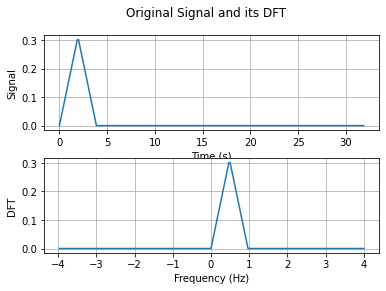

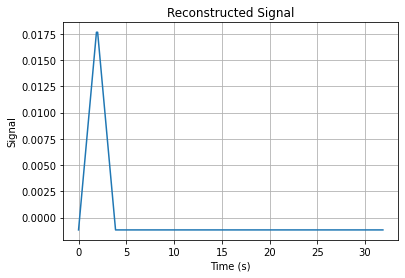

/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:86: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_c=np.roll(self.X,np.int(np.ceil(self.K/2-1)))
/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:111: ComplexWarning: Casting complex values to real discards the imaginary part
  x[n] = (self.X[0]*np.exp(1j*2*cmath.pi*n/self.N))*(1/np.sqrt(self.N))
/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:113: ComplexWarning: Casting complex values to real discards the imagin

1
0.8898925781250002


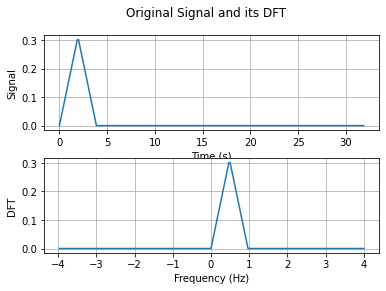

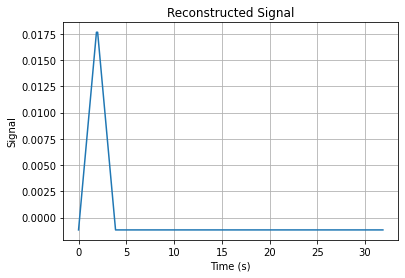

/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:86: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_c=np.roll(self.X,np.int(np.ceil(self.K/2-1)))
/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:111: ComplexWarning: Casting complex values to real discards the imaginary part
  x[n] = (self.X[0]*np.exp(1j*2*cmath.pi*n/self.N))*(1/np.sqrt(self.N))
/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:113: ComplexWarning: Casting complex values to real discards the imagin

1
0.8898925781250002


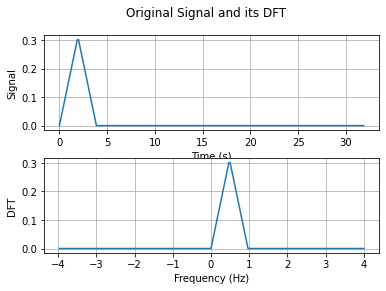

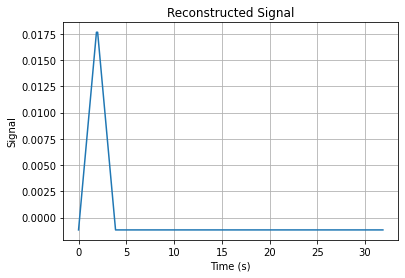

In [10]:

q_14(32, 8, 4, [2, 4, 8, 16])

The trianglar pulse has less change than the square pulse, therefore triangular pulse is easier to reconstruct than the square pulse.

**1.5**\
From the given question, we know that the energy we are computing is given by : \
$||p_k||^2 = \sum_{n=0}^{N-1}|p_k (n)|^2 = \sum_{n=0}^{N-1}|x(n) - \tilde{x}_k(n)|^2$ \
We can convert this to:\
$\sum_{k=0}^{N-1}|X(k) - \tilde{X}(k)|^2 = \sum_{k=-N/2+1}^{N/2}|X(k) - \tilde{X}(k)|^2$\
Since $X(k) - \tilde{X}(k) = 0$ and $X(k) - \tilde{X}(k) = X(k)$, this becomes\
$\sum_{|k|>|K|} |X(k)|^2$\
From this we know that the larger K gets the smaller the energy difference gets, which means tge reconstructed signal is closer to the initial signal. \
This reminds me of the rectangle method which is used to approximate integrals.\
In a similar fashion, as you increase the number of rectangles used, the rectangle method gets closer to the actual area under the curve.

/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:86: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_c=np.roll(self.X,np.int(np.ceil(self.K/2-1)))
/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/250481848.py:9: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more d

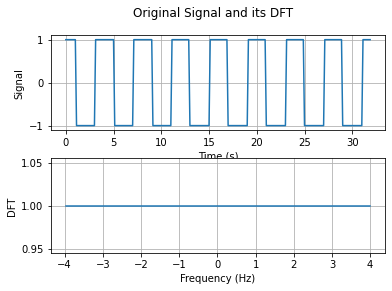

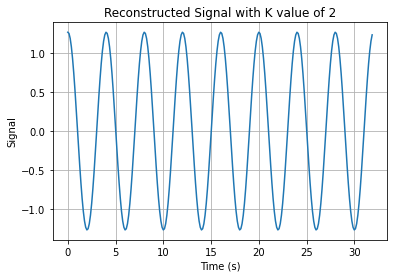

/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:86: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_c=np.roll(self.X,np.int(np.ceil(self.K/2-1)))
/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/250481848.py:9: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more d

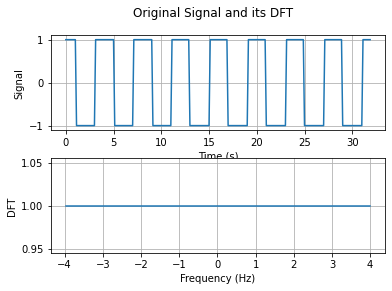

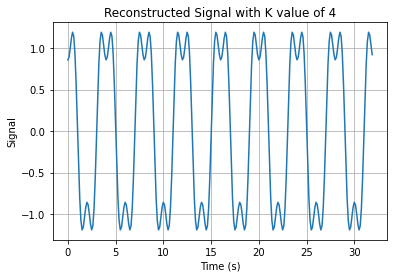

/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:86: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_c=np.roll(self.X,np.int(np.ceil(self.K/2-1)))
/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/250481848.py:9: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more d

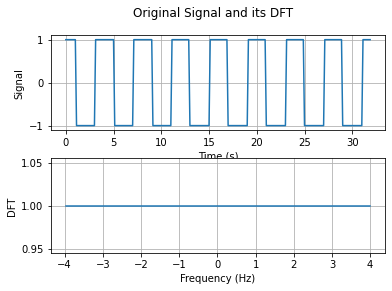

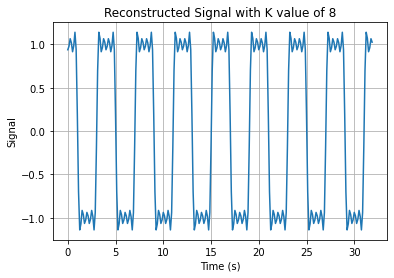

/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/355403542.py:86: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_c=np.roll(self.X,np.int(np.ceil(self.K/2-1)))
/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_5043/250481848.py:9: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more d

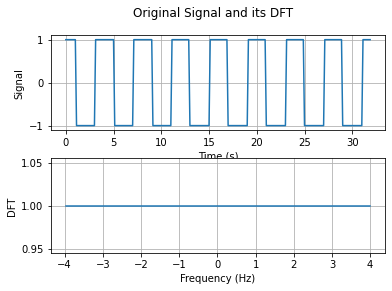

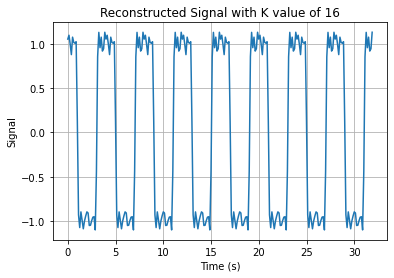

In [11]:
class q_16():
    def __init__(self, x, fs, k):
        self.x=x
        self.N= len(x)
        self.fs=fs
        self.k=k
    #similar calculations as the iDFT class, but we only take the largest k coefficients and their frequencies.
    def solve(self):
        X = np.zeros(self.N, dtype=np.complex)
        E = np.zeros(self.N)
        Xk = np.zeros(self.k, dtype=np.complex)
        index = np.zeros(self.k)
        r = range(self.N)
        for k in r:
            for n in r:
                X[k] = X[k] + 1 / np.sqrt(self.N) * self.x[n] * np.exp(-1j * 2 * cmath.pi * k * n / self.N)
        f_k = np.arange(self.N) / self.N * self.fs

        for k in range(self.N):
            E[k] = abs(X[k])
        index_temp = np.argsort(-E)
        index = index_temp[0:self.k]
        index = index[:, np.newaxis]
        X_K = X[index] 
        X_K = np.concatenate((X_K, index), axis=1) 
        return X_K, f_k
        

class sigReconstruction():

    def __init__(self, X_k, fk):
       
        self.X=X_k
        self.fk=fk
        self.N=len(fk)
        self.K=self.X.shape[0]

    def solve(self):
        x=np.zeros(self.N)
        
        for n in range(self.N):
            for k in range(self.K):
                x[n] = x[n]+1/np.sqrt(self.N)*self.X[k,0]*np.exp(1j*2*cmath.pi*self.X[k,1]*n/self.N)
            
        return x 

def q_18(T, fs, T0, K):

    
    sp = Sqpulse(T, T0, fs)    
    x, N = sp.solve()
    DFT_K = q_16(x,fs,K)
    X_K, fk = DFT_K.solve()
    
    iDFT = sigReconstruction(X_K, fk)
    xhat_K = iDFT.solve()
    
    Ts= 1/fs
    Treal= np.arange(N)*Ts
    
    # Plot
    fig, axs = plt.subplots(2)
    axs[0].grid()
    axs[1].grid()
    fig.suptitle('Original Signal and Reconstructed Signal' )
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    axs[0].plot(Treal, x)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Signal')
    axs[1].plot(Treal, xhat_K)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Signal')
    plt.show() 

class sqwave():

    def __init__(self, T, f0, fs):
       
        self.T = T
        self.f0 = f0
        self.fs = fs
        self.N = T*fs
                
    def solve(self):
        
        n = np.arange(self.N)
        x = np.sign(np.cos(2*cmath.pi*self.f0/self.fs*n))
        
        return x, self.N

def q_19(T, fs, f0, K):

    
    sp = sqwave(T, f0, fs)    
    x, N = sp.solve()
    DFT = Dft(x,fs)
    [f,X,f_c,X_c] = DFT.first()      
    DFT_K = q_16(x,fs,K)
    X_K, fk = DFT_K.solve()
    iDFT = sigReconstruction(X_K, fk)
    xhat_K = iDFT.solve()
    Ts= 1/fs
    Treal= np.arange(N)*Ts
    fig, axs = plt.subplots(2)
    axs[0].grid()
    axs[1].grid()
    fig.suptitle('Original Signal and its DFT' )
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    axs[0].plot(Treal, x)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Signal')
    axs[1].plot(f_c, abs(X_c))
    axs[1].set_xlabel('Frequency (Hz)')
    axs[1].set_ylabel('DFT')
    plt.show()
    fig.savefig("Square_Wave_DFT.png", bbox_inches='tight')
    
    plt.figure()
    plt.grid(True)
    plt.title('Reconstructed Signal with K value of ' + str(K))
    plt.plot(Treal, xhat_K)
    plt.xlabel('Time (s)')
    plt.ylabel('Signal')
    plt.savefig('Square_Wave_reconstructed.png')
    plt.show()

q_19(32,8,0.25,2)
q_19(32,8,0.25,4)
q_19(32,8,0.25,8)
q_19(32,8,0.25,16)






    

**1.7**\
The answer to this question is essentially the answer to 1.5.\
As we mathematically proved in 1.5, the largest K values have a smaller energy difference, which makes the compression more accurate.

**1.9**
A square pulse only occurs once, while a wave has a repeating motion.
Since the wave is repetitive, it can be approximated more accurately by a selection of the largest DFT coefficients.

In [5]:
!pip3 install libportaudio2
!pip3 install sounddevice

ERROR: Could not find a version that satisfies the requirement libportaudio2 (from versions: none)
ERROR: No matching distribution found for libportaudio2


In [7]:
import sounddevice as sd
import matplotlib.pyplot as plt
import cmath
import numpy as np
import math
class recordsound():
   
    def __init__(self, T, fs):
        
        self.T = T
        self.fs = fs
                
    def solve(self):
        
        print('start ')
        voicerecording = sd.rec(int(self.T * self.fs), self.fs, 1)
        sd.wait()  # Wait until recording is finished
        print('end ')
        write('myvoice.wav', self.fs, voicerecording)  # Save as WAV file 
        
        return voicerecording

recording = recordsound(5,20)

In [2]:
import matplotlib.pyplot as plt
import cmath
import numpy as np
import math

class recordsound():
    """
    recordsound Record your voice for T time sampled at a frequency fs
    solve() generates a sampled signal of your voice and save it into a wav file
    """
    def __init__(self, T, fs):
        """
        :param T: the duration time
        :param fs: the sampling frequency
        """
        self.T = T
        self.fs = fs
                
    def solve(self):
        """
        :return: [x,N]
        :x: the triangular pulse vector x
        :N: The sample duration
        """
        print('start recording')
        voicerecording = sd.rec(int(self.T * self.fs), self.fs, 1)
        sd.wait()  # Wait until recording is finished
        print('end recording')
        write('myvoice.wav', self.fs, voicerecording)  # Save as WAV file 
        
        return voicerecording


def q_21(T, fs):
    """
    Question 2.2_first K DFT coefficients
    
    """

    myvoice = recordsound(T, fs)  
    x = myvoice.solve().reshape(T*fs)
    N = len(x)

    DFT = Dft(x,fs)
    [freqs, X, f_c, X_c] = DFT.solve3()
    
    Ts= 1/fs
    Treal= np.arange(N)*Ts
    
    # Plot
    fig, axs = plt.subplots(2)
    axs[0].grid()
    axs[1].grid()
    fig.suptitle('Original Voice and its DFT' )
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    axs[0].plot(Treal, x)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Signal')
    axs[1].plot(f_c, X_c)
    axs[1].set_xlabel('Frequency (Hz)')
    axs[1].set_ylabel('DFT')
    plt.show()     
    fig.savefig("Recorded_Voice_and_DFT.png", bbox_inches='tight')

In [15]:


def q_22_1(T, fs, gamma):
    """
    Question 2.2_first K DFT coefficients
    
    """

    myvoice = recordsound(T, fs)  
    x = myvoice.solve().reshape(T*fs)
    N = len(x)

    DFT = Dft(x,fs)
    [freqs, X, f_c, X_c] = DFT.first()
    
    truncated_sample = int(N*gamma)
    X_truncated = np.zeros(N, dtype=np.complex)
    X_truncated[0:truncated_sample] = X[0:truncated_sample]
    
    iDFT = Inversedft(X_truncated, fs, N)
    xhat_K, Treal = iDFT.solve_ifft()
    
    write('myvoice_truncated.wav', fs, xhat_K.real)
    
    # Plot
    fig, axs = plt.subplots(2)
    axs[0].grid()
    axs[1].grid()
    fig.suptitle('Original Voice and Reconstructed Voice' )
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    axs[0].plot(Treal, x)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Signal')
    axs[1].plot(Treal, xhat_K)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Signal')
    plt.show()     
    fig.savefig("Reconstructed_Voice.png", bbox_inches='tight')

def q_22_2(T, fs, gamma):
    """
    Question 2.2 _K DFT coefficients with largest energy
    """
    
    myvoice = recordsound(T, fs)  
    x = myvoice.solve().reshape(T*fs)
    N = len(x)

    DFT = Dft(x,fs)
    [freqs, X, f_c, X_c] = DFT.first()
    
    truncated_sample = int(N*gamma/2)
    X_truncated = np.zeros(N, dtype=np.complex)
    E=np.zeros(N)
    for k in range(N):
        E[k]=abs(X[k])
    index_temp=np.argsort(-E)
    index=index_temp[0:truncated_sample]
    X_truncated[index]=X[index]
    
    iDFT = Inversedft(X_truncated, fs, N)
    Treal, xhat_K = iDFT.idft_basic()
    
    # Plot
    fig, axs = plt.subplots(2)
    axs[0].grid()
    axs[1].grid()
    fig.suptitle('Original Voice and Reconstructed Voice' )
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    axs[0].plot(Treal, x)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Signal')
    axs[1].plot(Treal, xhat_K)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Signal')
    plt.show()     
    fig.savefig("Reconstructed_Voice_Largest.png", bbox_inches='tight')



In [15]:


def q_23(T, fs, threshold):
    """
    Question 2.3
    
    """
    myvoice = recordsound(T, fs)  
    x = myvoice.solve().reshape(T*fs)
    N = len(x)

    DFT = Dft(x,fs)
    [freqs, X, f_c, X_c] = DFT.first()    
    
    for k in range(N):
        E=abs(X[k])
        if E > threshold:
            X[k] = 0
    
    iDFT = Inversedft(X, fs, N)
    Treal, xhat_K = iDFT.idft_basic()
    
    # Plot
    fig, axs = plt.subplots(2)
    axs[0].grid()
    axs[1].grid()
    fig.suptitle('Original Signal and Reconstructed Signal' )
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    axs[0].plot(Treal, x)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Signal')
    axs[1].plot(Treal, xhat_K)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Signal')
    plt.show() 
    fig.savefig("Reconstructed_Voice_Masking.png", bbox_inches='tight')



KeyboardInterrupt: 

In [ ]:
def q_24(T, fs, gamma):
    """
    Question 2.4
    
    """
    
    myvoice = recordsound(T, fs)  
    x = myvoice.solve().reshape(T*fs)
    N = len(x)
    chunks = T*10
    chunk_sample = 0.1*fs
    x_recon = []
    
    for i in range(chunks):        
        current_chunk = x[int(i*chunk_sample):int(i*chunk_sample+chunk_sample)]
        n = len(current_chunk)
        DFT_chunk = Dft(current_chunk, fs)
        [freqs_chunk, X_chunk, f_c_chunk, X_c_chunk] = DFT_chunk.first()
        K = int(n*gamma)
        X_chunk_truncated = np.zeros(n,dtype=np.complex)
        X_chunk_truncated[0:K] = X_chunk[0:K]
        iDFT = Inversedft(X_chunk_truncated, fs, n)
        Treal, x_idft = iDFT.idft_basic() 
        x_recon = np.concatenate([x_recon, x_idft])
    Ts= 1/fs
    Treal= np.arange(N)*Ts
        
    # Plot
    fig, axs = plt.subplots(2)
    axs[0].grid()
    axs[1].grid()
    fig.suptitle('Original Signal and Reconstructed Signal' )
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    axs[0].plot(Treal, x)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Signal')
    axs[1].plot(Treal, x_recon)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Signal')
    plt.show() 
    fig.savefig("MP3_compressor.png", bbox_inches='tight')